# **---------------TRANSFORMER MODEL FOR TIME SERIES---------------**

**Importing dataset from Github and installing a package**

In [1]:
%%capture
!git clone https://github.com/alphaameer007/RHM_FYP
!pip install torchmetrics

**Importing necessary libraries/packages**

In [2]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchmetrics import MeanAbsoluteError, MeanAbsolutePercentageError
import os
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import TensorDataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


**Importing data as dataframe**

In [3]:
df=pd.read_csv('/kaggle/working/RHM_FYP/TurkeyWindFarm.csv')
df

,time,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,1/1/2018 0:00,380.047791,5.311336,416.328908,259.994904
1,1/1/2018 0:10,453.769196,5.672167,519.917511,268.641113
2,1/1/2018 0:20,306.376587,5.216037,390.900016,272.564789
3,1/1/2018 0:30,419.645904,5.659674,516.127569,271.258087
4,1/1/2018 0:40,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...,...
52555,12/31/2018 23:10,2963.980957,11.404030,3397.190793,80.502724
52556,12/31/2018 23:20,1684.353027,7.332648,1173.055771,84.062599
52557,12/31/2018 23:30,2201.106934,8.435358,1788.284755,84.742500
52558,12/31/2018 23:40,2515.694092,9.421366,2418.382503,84.297913


# **Data Preparation (using sliding window technique)**

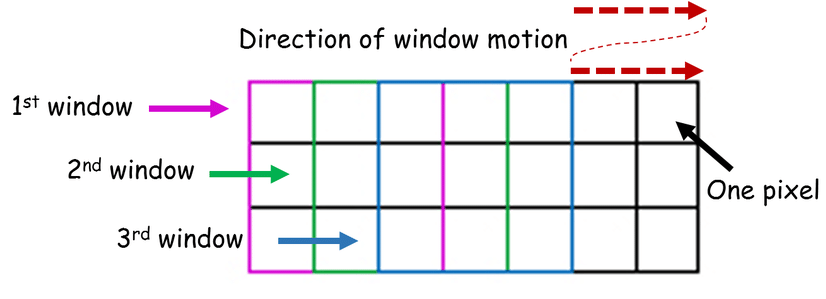

**Don't need time information in our case**

In [4]:
df.drop('time', inplace=True, axis=1)
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,380.047791,5.311336,416.328908,259.994904
1,453.769196,5.672167,519.917511,268.641113
2,306.376587,5.216037,390.900016,272.564789
3,419.645904,5.659674,516.127569,271.258087
4,380.650696,5.577941,491.702972,265.674286
...,...,...,...,...
52555,2963.980957,11.404030,3397.190793,80.502724
52556,1684.353027,7.332648,1173.055771,84.062599
52557,2201.106934,8.435358,1788.284755,84.742500
52558,2515.694092,9.421366,2418.382503,84.297913


**Normalizing data in between range [0,1]**

In [5]:
max_values = df.max()              #normalizing data in between range [0,1]
df = df.div(max_values) 
df

,LV ActivePower (kW),Wind Speed (m/s),wind energy,Wind Direction (°)
0,0.105022,0.210717,0.115647,0.722213
1,0.125394,0.225032,0.144422,0.746230
2,0.084664,0.206936,0.108583,0.757129
3,0.115965,0.224537,0.143369,0.753500
4,0.105189,0.221294,0.136584,0.737989
...,...,...,...,...
52555,0.819066,0.452433,0.943664,0.223620
52556,0.465454,0.290909,0.325849,0.233509
52557,0.608253,0.334657,0.496746,0.235397
52558,0.695186,0.373775,0.671773,0.234162


**Permuting columns so that we can split dataset easily**

In [6]:
#switching columns to make LV activePower (kW) last column so that it will be easy
# to prepare training and test datasets
cols = df.columns.tolist()
cols[0], cols[3] = cols[3], cols[0]
df = df[cols]
df

,Wind Direction (°),Wind Speed (m/s),wind energy,LV ActivePower (kW)
0,0.722213,0.210717,0.115647,0.105022
1,0.746230,0.225032,0.144422,0.125394
2,0.757129,0.206936,0.108583,0.084664
3,0.753500,0.224537,0.143369,0.115965
4,0.737989,0.221294,0.136584,0.105189
...,...,...,...,...
52555,0.223620,0.452433,0.943664,0.819066
52556,0.233509,0.290909,0.325849,0.465454
52557,0.235397,0.334657,0.496746,0.608253
52558,0.234162,0.373775,0.671773,0.695186


**Checking the shape of our target variable**

In [7]:
target=df['LV ActivePower (kW)']
target.shape

(52560,)

**Preparing our dataset in a sliding window fashion with a particular window size**

In [8]:
# Calculate the number of readings per day
readings_per_day = 144

#n = number of day
n = 3

# Calculate the sequence length (n days in readings)
sequence_length = readings_per_day * n

# Set the lookback window to be the same as the sequence length
lookback_window = sequence_length

# Convert the data to a NumPy array
df = df.values

x, y = [], []
for i in range(lookback_window, len(df)):
    x.append(df[i - lookback_window:i, :])
    y.append(df[i, -1])
x = np.array(x)
y = np.array(y)
print(x.shape)
print(y.shape)

(52128, 432, 4)
(52128,)


**Splitting our test and training part of dataset**

In [9]:
# Calculate the number of test samples (last 3 days of the year)
num_test_samples = readings_per_day * 3

# Split the data into training and test sets
x_train = x[:-num_test_samples]
y_train = y[:-num_test_samples]
x_test = x[-num_test_samples:]
y_test = y[-num_test_samples:]

**Checking the shape of our train and test set**

In [10]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(51696, 432, 4)
(51696,)
(432, 432, 4)
(432,)


# **Transformer Model**

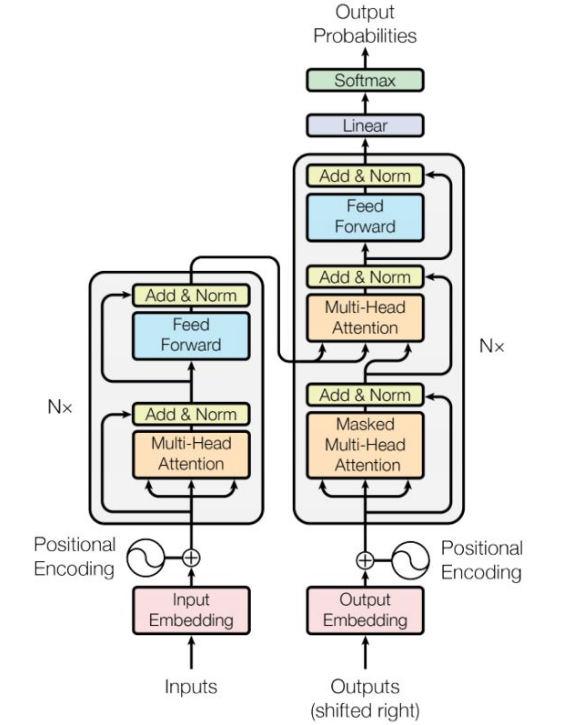

**Positional Encoding class to make transformer aware of sequencial order**

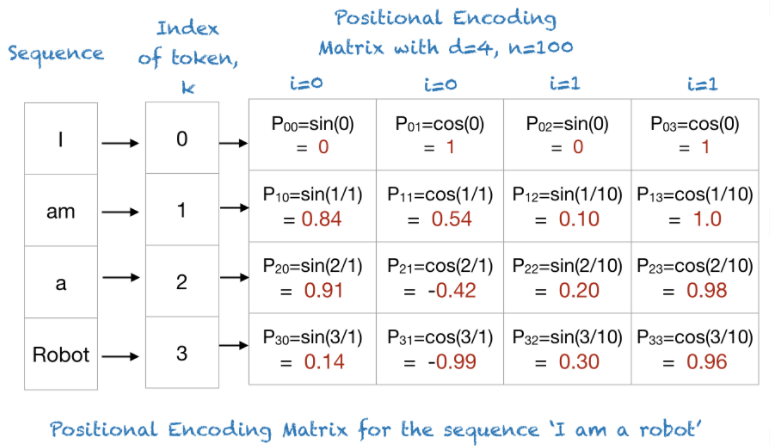

In [11]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_size, dropout_p, max_len):
        super().__init__()
        self.dropout = nn.Dropout(dropout_p)
        position = torch.arange(max_len).unsqueeze(1)                                                           #col vector    #add another dimension from (max_len) -> (maxlen,1)
        div_term = torch.exp(torch.arange(0, embedding_size, 2).float() * (-math.log(10000.0)) / embedding_size)#row vector    #1 / 10000^(2i/embedding_size) -> div_term
        sinusoid = torch.zeros(max_len, embedding_size)                                                         # (max_len,embedding size)
        sinusoid[:, 0::2] = torch.sin(position * div_term)                                                      #col * row     # (time_step , even embedding added with sine  * div_term)
        sinusoid[:, 1::2] = torch.cos(position * div_term)                                                      # (time_step , odd embedding added with cosine * div_term) 
        self.register_buffer('pos_encoding', sinusoid.unsqueeze(0))                                             #creating register buffer in pytorch graph

    def forward(self, x):
        pos_encoding = self.pos_encoding[:, :x.size(1), :]                                                      # Resize pos_encoding to match the input size of x
        x = x + pos_encoding                                                                                    #addition of positional encoding with our embedded input
        return self.dropout(x)

**Transformer Model Declaration**

In [12]:
class Transformer(nn.Module):
    def __init__(self, input_size, dim_model, num_heads, num_encoder_layers, num_decoder_layers, dropout_p, out_size, device):
        super().__init__()
        self.model_type = "Transformer"
        self.dim_model = dim_model
        self.positional_encoder = PositionalEncoding(embedding_size=dim_model, dropout_p=dropout_p, max_len=432)
        self.embedding = nn.Linear(input_size, dim_model)
        self.transformer = nn.Transformer(d_model=dim_model, nhead=num_heads, num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, dropout=dropout_p)
        self.out = nn.Linear(dim_model, out_size)

    def get_tgt_mask(self, tgt_len):
        # Function to create a square attention mask for the decoder
        mask = torch.triu(torch.ones(tgt_len, tgt_len)) == 1
        mask = mask.float().masked_fill(mask == 0, float("-inf")).masked_fill(mask == 1, float(0.0))
        return mask

    def forward(self, x):
        # x shape: (batch_size, sequence_length, num_features)
        
        x = self.embedding(x) * math.sqrt(self.dim_model)
        x = self.positional_encoder(x)
        x = x.permute(1, 0, 2)  # (sequence_length, batch_size, dim_model)
        transformer_out = self.transformer(x, x, tgt_mask=self.get_tgt_mask(x.size(0)).to(device))
        out = self.out(transformer_out[-1])
        return out.squeeze()

**Initializing Transformer model by passing its parameters**

In [13]:
# Define model parameters
seq_length = lookback_window
input_size = x_train.shape[-1]
dim_model = 512
num_heads = 8
num_encoder_layers = 3
num_decoder_layers = 3
dropout_p = 0.2
out_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
model = Transformer(
    input_size=input_size,
    dim_model=dim_model,
    num_heads=num_heads,
    num_encoder_layers=num_encoder_layers,
    num_decoder_layers=num_decoder_layers,
    dropout_p=dropout_p,
    out_size=out_size,
    device = device
)


In [14]:
if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    model = nn.DataParallel(model)

model.to(device)

Let's use 2 GPUs!


DataParallel(
  (module): Transformer(
    (positional_encoder): PositionalEncoding(
      (dropout): Dropout(p=0.2, inplace=False)
    )
    (embedding): Linear(in_features=4, out_features=512, bias=True)
    (transformer): Transformer(
      (encoder): TransformerEncoder(
        (layers): ModuleList(
          (0-2): 3 x TransformerEncoderLayer(
            (self_attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
            )
            (linear1): Linear(in_features=512, out_features=2048, bias=True)
            (dropout): Dropout(p=0.2, inplace=False)
            (linear2): Linear(in_features=2048, out_features=512, bias=True)
            (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (dropout1): Dropout(p=0.2, inplace=False)
            (dropout2): Dropout(p=0.2, inplace=False)
          )
        )

**Converting to tensors while also mounting them on the same device as the model**

In [15]:
# Convert data to tensors
x_train_tensor = torch.tensor(x_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)

**Training the model after declaring optimizer, loss, metric and no. epochs**

In [16]:
from prettytable import PrettyTable
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
#count_parameters(model)

Transformer model have 22,074,369 million trainable parameters.

In [17]:
use_amp = True
scaler = torch.cuda.amp.GradScaler(enabled=use_amp)
# Define loss function and optimizer
criterion_1 = nn.MSELoss()                                          # MSE
criterion_2 = nn.L1Loss()                                           # MAE (L1)
criterion_3 = MeanAbsoluteError().to(device)                        # MAE
metricc = MeanAbsolutePercentageError().to(device)                  # MAPE metric
optimizer = optim.Adam(model.parameters(), lr=1e-4)                 # Adam

lossInfo = []
metricInfo = []

# Create the PyTorch DataLoader
batch_size = 128
train_loader = DataLoader(dataset=TensorDataset(x_train_tensor, y_train_tensor),
                          batch_size=batch_size, shuffle=True)

# Training parameters
num_epochs = 1

# Check if model weights exist
weights_folder = "/kaggle/working/RHM_FYP/TransformerWeights/"
if not os.path.exists(weights_folder):
    os.makedirs(weights_folder)
model_file = os.path.join(weights_folder, "model_weights.pth")
epoch_file = os.path.join(weights_folder, "epoch_counter.pth")
loss_file = os.path.join(weights_folder, "LossInfo.txt")
metric_file = os.path.join(weights_folder, "MetricInfo.txt")
if os.path.exists(model_file) and os.path.exists(epoch_file):
    # Load weights and epoch counter
    model.load_state_dict(torch.load(model_file))
    epoch_counter = torch.load(epoch_file)
    print(f"Resuming training from epoch {epoch_counter}")
else:
    epoch_counter = 0
    print("Starting training from scratch")

# Train the model on GPU
for epoch in range(num_epochs):
    
    # Initialize the running loss and metric for the epoch
    running_loss = 0.0
    running_metric = 0.0
    
    # Loop over the batches in the data loader
    for batch_idx, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch+1}", bar_format='{desc}: {percentage:3.0f}%|{bar:50}{r_bar}'):
        # Move the data and target to the GPU
        data, target = data.to(device), target.to(device)
        
        
        
        # Forward pass
        with torch.autocast(device_type= 'cuda', dtype=torch.float16, enabled=use_amp):
            output = model(data)
            loss = criterion_3(output.view(-1), target)
            metric_val = metricc(output.view(-1), target)
        
        # Backward pass and optimization
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        # Reset the optimizer gradients
        optimizer.zero_grad(set_to_none=True)
        
        # Update the running loss and metric for the epoch
        running_loss += loss.item()
        running_metric += metric_val.item()
    
    # Calculate the average loss and metric for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_metric = running_metric / len(train_loader)
    lossInfo.append(epoch_loss)
    metricInfo.append(epoch_metric)
    print("-"*25, f"Epoch {epoch + 1}","-"*25)
    print(f"Epoch {epoch+1} MAE loss: {epoch_loss:.9f}")
    print(f"Epoch {epoch+1} MAPE metric: {epoch_metric:.9f}")
    
    # Save model weights and epoch counter
    torch.save(model.state_dict(), model_file)
    torch.save(epoch+1, epoch_file)

    # Save loss and metric information
    if not os.path.exists(loss_file):
        with open(loss_file,'x') as file:
            file.write(str(lossInfo))
    else:
        with open(loss_file,"w") as file:
            file.write(str(lossInfo))

    if not os.path.exists(metric_file):
        with open(metric_file,'x') as file:
            file.write(str(metricInfo))
    else:
        with open(metric_file,"w") as file:
            file.write(str(metricInfo))

print("Training completed!")

Starting training from scratch


Epoch 1: 100%|██████████████████████████████████████████████████| 404/404 [03:44<00:00,  1.80it/s]

------------------------- Epoch 1 -------------------------
Epoch 1 MAE loss: 0.168036192
Epoch 1 MAPE metric: 47.315364433
Training completed!


**Downloading the weights of the model**

Or
```
!zip -r folder_name.zip folder_name/
```

In [18]:
!zip -r /kaggle/working/TransformerWeights.zip /kaggle/working/RHM_FYP/TransformerWeights

  adding: kaggle/working/RHM_FYP/TransformerWeights/ (stored 0%)
  adding: kaggle/working/RHM_FYP/TransformerWeights/MetricInfo.txt (stored 0%)
  adding: kaggle/working/RHM_FYP/TransformerWeights/model_weights.pth (deflated 8%)
  adding: kaggle/working/RHM_FYP/TransformerWeights/LossInfo.txt (stored 0%)
  adding: kaggle/working/RHM_FYP/TransformerWeights/epoch_counter.pth (deflated 63%)


In [19]:
import os
os.chdir(r'/kaggle/working')

from IPython.display import FileLink

FileLink(r'TransformerWeights.zip') #click on the generated link to download model weights ;)

/kaggle/working/TransformerWeights.zip

**Plotting the loss and metric trend throughout the training of model**

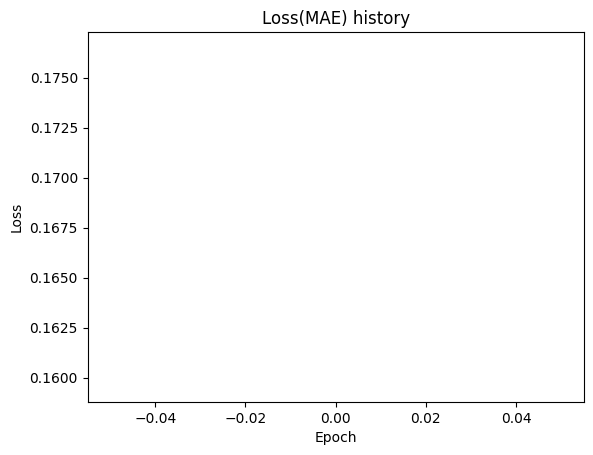

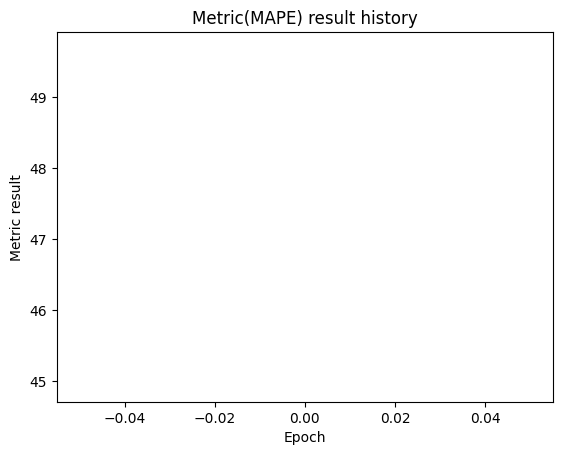

In [20]:
with open(loss_file, 'r') as file:
    temp = file.read()
lossInfo = list(eval(temp))
# Plot the history of loss
plt.plot(range(num_epochs), lossInfo)
plt.title('Loss(MAE) history')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

with open(metric_file, 'r') as file:
    temp = file.read()
metricInfo = list(eval(temp))
# Plot the history of metric result
plt.plot(range(num_epochs), metricInfo)
plt.title('Metric(MAPE) result history')
plt.xlabel('Epoch')
plt.ylabel('Metric result')
plt.show()

**Testing model performance on testset**

In [21]:
model.load_state_dict(torch.load('/kaggle/working/RHM_FYP/TransformerWeights/model_weights.pth'))

<All keys matched successfully>

In [22]:
# Convert test data to tensor
x_test_tensor = torch.tensor(x_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [23]:
batch_size = 1
modPred = []
GroundTruth = []

In [26]:
running_loss = 0.0                                             # MAE Loss
running_metric = 0.0                                           # MAPE metric
for i in tqdm(range(0, len(x_test_tensor), batch_size), desc=f"Train set inference ..."): # change 50 to len(x_test_tensor)
        # Get batch of inputs and targets
        batch_x = x_test_tensor[i:i+batch_size]
        batch_y = y_test_tensor[i:i+batch_size]
        
        # Reshape input tensor
        batch_x = batch_x.view(-1, seq_length, input_size)

        # Forward pass
        with torch.inference_mode():
            outputs = model(batch_x)
        #print(outputs.view(-1).shape)
        modPred.append(outputs.view(-1).cpu().detach())
        GroundTruth.append(batch_y.cpu().detach())
        loss = criterion_3(outputs.view(-1), batch_y)
        metric = metricc(outputs.view(-1), batch_y)
        running_loss += loss.item()
        running_metric += metric.item()

test_loss = running_loss / (len(x_train) / batch_size)
test_metric = running_metric / (len(x_train) / batch_size)
print("-"*25, "TEST LOSS", "-"*25)
print(f"Test MAE loss: {test_loss:.9f}")
print(f"Test MAPE metric: {test_metric:.9f}")

Train set inference ...: 100%|██████████| 432/432 [00:07<00:00, 54.48it/s]

------------------------- TEST LOSS -------------------------
Test MAE loss: 0.000526866
Test MAPE metric: 0.183092940


**Plotting the prediction of transformer on test with the ground truth**

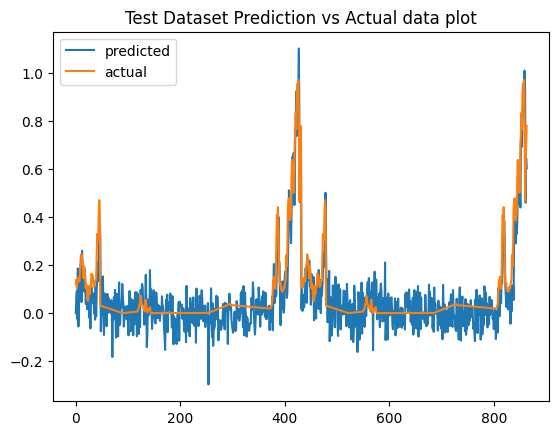

In [27]:
plt.plot(modPred)
plt.plot(GroundTruth)
plt.title('Test Dataset Prediction vs Actual data plot')
plt.legend(['predicted', 'actual'])
plt.show()